In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import GroupKFold
from scipy.sparse import csc_matrix,bmat
import xgboost as xgb
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = pd.concat([pd.read_csv('data/%d.csv' % year, 
                                  usecols=['Year','Course_#','Permanent_Tournament_#','Round','Hole','Player_#',
                                           'Start_X_Coordinate','End_X_Coordinate',
                                           'Start_Y_Coordinate','End_Y_Coordinate',
                                           'Start_Z_Coordinate','End_Z_Coordinate','last_shot_mask','Distance',
                                           'Strokes_from_starting_location','Cat','Distance_from_hole',
                                           'Green_to_work_with','Shot','loc_string','loc_string_hole'])
                      for year in range(2003,2018)])

In [ ]:
id_cols = ['Year','Permanent_Tournament_#','Course_#','Round','Hole']
cats = ['Green','Fairway','Intermediate Rough','Primary Rough','Fringe','Bunker','Other']

z_of_hole = data[data.last_shot_mask].groupby(id_cols)['End_Z_Coordinate'].max().to_dict()
data['Start_Z_Coordinate'] = data['Start_Z_Coordinate'] - np.array([z_of_hole[tuple(tup)] for tup in data[id_cols].values])
data['Start_Z_Coordinate'] = data['Start_Z_Coordinate'].fillna(0)

data['dist_using_coords'] = ((data.Start_X_Coordinate-data.End_X_Coordinate)**2
                             + (data.Start_Y_Coordinate-data.End_Y_Coordinate)**2)**.5
data['dist_error'] = (data.Distance/12.0 - data.dist_using_coords)/(data.Distance/12.0).replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=['dist_error'])
#print data.shape[0]
data = data[~((data.Cat=='Green') & (data.Distance_from_hole>130))]
#print data.shape[0]
data = data[data.dist_error.abs()<.1]
#print data.shape[0]

data = data.drop(['End_Z_Coordinate','last_shot_mask','dist_using_coords','dist_error',
                  'Start_X_Coordinate','End_X_Coordinate','Start_Y_Coordinate','End_Y_Coordinate'],axis=1)

In [136]:
data_ = data[data.Cat=='Fairway']
groups = ['-'.join(map(str,tup)) for tup in data_[id_cols].values.tolist()]
le = LabelEncoder()
groups = le.fit_transform(groups)
groups_dict = {group:u for u,group in enumerate(set(groups))}
perm = np.random.permutation(len(groups_dict))
groups = [perm[groups_dict[group]] for group in groups]

cols = ['Distance_from_hole','Start_Z_Coordinate','Green_to_work_with']
X = data_[cols].values
y = data_.Strokes_from_starting_location.values

In [137]:
lb = LabelBinarizer(sparse_output=True)
cols = ['Course_#',['Course_#','Year'],['Course_#','Year','Round'],['Course_#','Hole']]
to_encode = []
for col in cols:
    if isinstance(col,str):
        to_encode.append([str(s) for s in data_[col].values])
    else:
        to_encode.append(['-'.join(map(str,tup)) for tup in data_[col].values])
X_ = bmat([[lb.fit_transform(c) for c in to_encode]],format='csc')
X = bmat([[csc_matrix(X),X_]],format='csc')

In [138]:
X.shape

(2612728, 4481)

In [7]:
X.shape

(1252660, 4492)

In [135]:
lb = LabelBinarizer(sparse_output=True)
X_ = bmat([[lb.fit_transform(data_[col].values) for col in ['loc_string','loc_string_hole']]],format='csc')
X = bmat([[X,X_]],format='csc')

In [136]:
X.shape

(1252660, 76930)

In [122]:
gbr = GradientBoostingRegressor(loss='huber',learning_rate=.01,n_estimators=10000,subsample=.8,verbose=5,alpha=.93,
                                max_features=.8)

In [123]:
def make_monitor(running_mean_len):
    def monitor(i,self,args):
        if np.mean(self.oob_improvement_[max(0,i-running_mean_len+1):i+1])<0:
            return True
        else:
            return False
    return monitor

In [124]:
monitor = make_monitor(10)

In [125]:
gbr.fit(X,y,monitor=monitor)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2836           0.0021          511.11m
         2           0.2815           0.0020          510.12m
         3           0.2800           0.0016          502.80m
         4           0.2780           0.0019          501.79m
         5           0.2763           0.0019          509.94m
         6           0.2748           0.0015          491.34m
         7           0.2730           0.0017          488.32m
         8           0.2715           0.0014          481.27m
         9           0.2696           0.0017          486.33m
        10           0.2687           0.0014          487.66m
        11           0.2667           0.0016          489.72m
        12           0.2652           0.0016          489.05m
        13           0.2640           0.0012          484.25m
        14           0.2625           0.0015          486.36m
        15           0.2607           0.0015          484.12m
       

GradientBoostingRegressor(alpha=0.93, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=3,
             max_features=0.8, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10000, presort='auto', random_state=None,
             subsample=0.8, verbose=5, warm_start=False)

In [136]:
dist = 10
gtww = 5
x, y = [], []
for elev in np.linspace(-3,3,1000):
    X_ = np.concatenate([np.array([dist,elev,gtww]),np.zeros(4489)]).reshape(1,-1)
    pred = gbr.predict(X_)
    x.append(elev)
    y.append(pred)

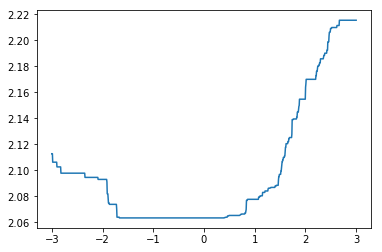

In [137]:
plt.plot(x,y);

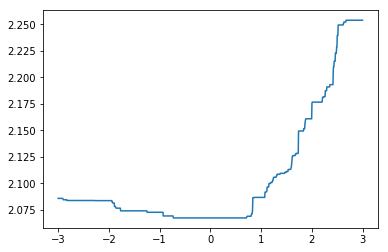

In [104]:
plt.plot(x,y);

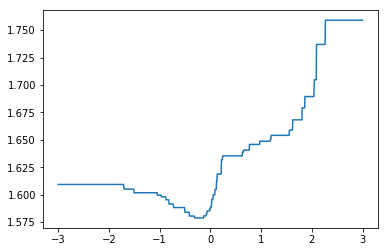

In [82]:
plt.plot(x,y);

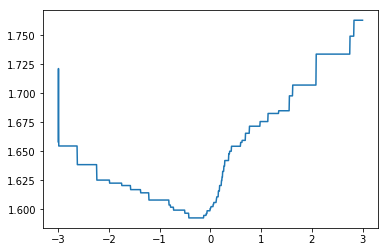

In [37]:
plt.plot(x,y);

In [133]:
elev = 0
gtww = 10
x, y1, y2 = [], [], []
for dist in np.linspace(0.01,1500,10000):
    x.append(dist)
    X_ = np.concatenate([np.array([dist,elev,gtww]),np.zeros(4489)]).reshape(1,-1)
    pred = gbr.predict(X_)
    y1.append(pred)
    X_ = np.concatenate([np.array([dist,elev,gtww]),[1],np.zeros(4488)]).reshape(1,-1)
    pred = gbr.predict(X_)
    y2.append(pred)

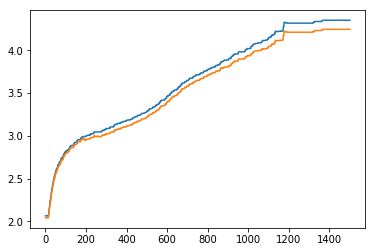

In [134]:
plt.plot(x,y1);
plt.plot(x,y2);

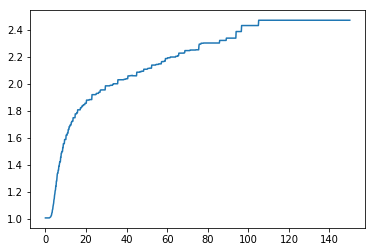

In [84]:
plt.plot(x,y);

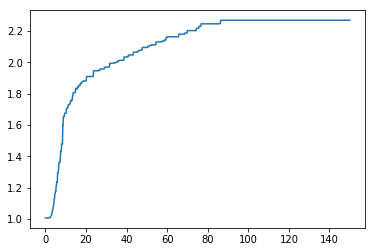

In [71]:
plt.plot(x,y);

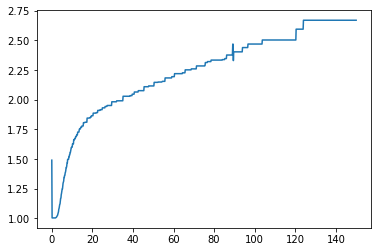

In [41]:
plt.plot(x,y);

In [42]:
data_.sort_values('Distance_from_hole').head(30)

,Year,Player_#,Course_#,Permanent_Tournament_#,Round,Hole,Shot,Distance,Start_Z_Coordinate,Strokes_from_starting_location,Distance_from_hole,Cat,Green_to_work_with,loc_string,loc_string_hole
691211,2005,12823,669,30,4,18,3,26,0.001,2,0.015282,Green,NaN,669-18-4-3,669-18-2-3
691734,2011,27933,538,47,3,17,5,13,-0.016,2,0.064848,Green,NaN,538-17-3-2,538-17-2-3
121130,2003,2133,500,7,3,4,3,3,0.004,2,0.066345,Green,NaN,500-4-6-1,500-4-3-1
31029,2004,1388,649,2,5,12,3,1,0.000,1,0.075003,Green,NaN,649-12-2-2,649-12-1-3
110164,2004,23613,5,5,1,17,3,1,0.000,1,0.075025,Green,NaN,5-17-1-1,5-17-1-1
1019215,2005,25732,717,473,4,7,4,1,0.000,1,0.075054,Green,NaN,717-7-5-2,717-7-3-3
301865,2003,20548,13,13,3,10,4,1,0.003,1,0.075079,Green,NaN,13-10-7-2,13-10-4-2
613193,2003,6581,612,29,1,18,5,1,-0.003,1,0.075082,Green,NaN,612-18-5-1,612-18-3-2
193182,2016,35300,734,10,1,2,5,1,0.000,1,0.075098,Green,NaN,734-2-14-2,734-2-5-3
105250,2011,31115,6,6,1,10,4,1,0.004,1,0.075117,Green,NaN,6-10-9-2,6-10-5-3


In [93]:
dist = 100
elev = .5
x, y = [], []
for gtww in np.linspace(.01,100,1000):
    X_ = np.array([[dist,elev,gtww]])
    pred = gbr.predict(X_)
    x.append(gtww)
    y.append(pred)

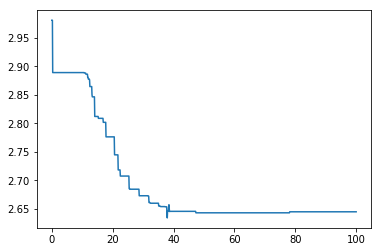

In [94]:
plt.plot(x,y);

In [140]:
dist = 100
x, y1, y2 = [], [], []
for gtww in np.linspace(.01,100,1000):
    x.append(gtww)
    X_ = np.concatenate([np.array([dist,-5,gtww]),np.zeros(4489)]).reshape(1,-1)
    pred = gbr.predict(X_)
    y1.append(pred)
    X_ = np.concatenate([np.array([dist,5,gtww]),np.zeros(4489)]).reshape(1,-1)
    pred = gbr.predict(X_)
    y2.append(pred)

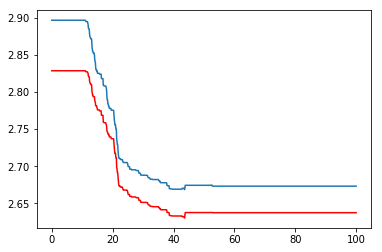

In [143]:
plt.plot(x,y1,c='r');
plt.plot(x,y2);

In [142]:
np.array(y1)-np.array(y2)

array([[-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0.06790947],
       [-0

In [8]:
cv = GroupKFold(n_splits=15)

In [142]:
for train,test in cv.split(X,y,groups):
    dtrain = xgb.DMatrix(X[train],label=y[train])
    dtest = xgb.DMatrix(X[test],label=y[test])
    break

In [208]:
params = {'objective':'reg:linear','eta':.01,'max_depth':10,'lambda':10.,'eval_metric':'mae',
          'min_child_weight':20,'subsample':.9,'silent':0,'tree_method':'approx'}
early_stopping_rounds = 50
num_round = 10000
watchlist  = [(dtrain,'train'),(dtest,'eval')]

In [89]:
def psuedo_huber(preds, dtrain):
    labels = dtrain.get_label()
    delta = psuedo_huber.delta
    resids = preds - labels
    #delta = np.mean(np.abs(np.percentile(resids,[100-delta,delta])))
    #print delta
    grad = resids * (1 + (resids/delta)**2)**(-.5)
    hess = (1 + (resids/delta)**2)**(-1.5)
    return grad, hess

In [142]:
bst = xgb.train(params,dtrain,num_round,watchlist,psuedo_huber,
                early_stopping_rounds=early_stopping_rounds,verbose_eval=True)

[0]	train-mae:1.26435	eval-mae:1.26159
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 rounds.
[1]	train-mae:1.1955	eval-mae:1.19288
[2]	train-mae:1.14153	eval-mae:1.13895
[3]	train-mae:1.09695	eval-mae:1.09424
[4]	train-mae:1.05879	eval-mae:1.05597
[5]	train-mae:1.02584	eval-mae:1.023
[6]	train-mae:0.996899	eval-mae:0.994022
[7]	train-mae:0.97138	eval-mae:0.968467
[8]	train-mae:0.94835	eval-mae:0.945377
[9]	train-mae:0.927231	eval-mae:0.924227
[10]	train-mae:0.907842	eval-mae:0.904825
[11]	train-mae:0.889803	eval-mae:0.886774
[12]	train-mae:0.872886	eval-mae:0.869858
[13]	train-mae:0.856856	eval-mae:0.853851
[14]	train-mae:0.841692	eval-mae:0.838708
[15]	train-mae:0.82725	eval-mae:0.824297
[16]	train-mae:0.813655	eval-mae:0.810739
[17]	train-mae:0.800654	eval-mae:0.797775
[18]	train-mae:0.788302	eval-mae:0.78546
[19]	train-mae:0.776544	eval-mae:0.773751
[20]	train-mae:0.76544	eval-mae:0.762714
[21]	tr

In [152]:
cols = ['Distance_from_hole','Start_Z_Coordinate','Green_to_work_with']
X = data_[cols].values
y = data_.Strokes_from_starting_location.values
lb = LabelBinarizer(sparse_output=True)
cols = ['Course_#',['Course_#','Year'],['Course_#','Year','Round'],['Course_#','Hole']]
to_encode = []
for col in cols:
    if isinstance(col,str):
        to_encode.append([str(s) for s in data_[col].values])
    else:
        to_encode.append(['-'.join(map(str,tup)) for tup in data_[col].values])
X_ = bmat([[lb.fit_transform(c) for c in to_encode]],format='csc')
X = bmat([[csc_matrix(X),X_]],format='csc')
for train,test in cv.split(X,y,groups):
    dtrain = xgb.DMatrix(X[train],label=y[train])
    dtest = xgb.DMatrix(X[test],label=y[test])
    break
watchlist  = [(dtrain,'train'),(dtest,'eval')]

In [133]:
bst = xgb.train(params,dtrain,num_round,watchlist,psuedo_huber,
                early_stopping_rounds=early_stopping_rounds,verbose_eval=True)

[0]	train-mae:1.26435	eval-mae:1.26159
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 50 rounds.
[1]	train-mae:1.19552	eval-mae:1.19291
[2]	train-mae:1.14173	eval-mae:1.13914
[3]	train-mae:1.09713	eval-mae:1.09445
[4]	train-mae:1.05885	eval-mae:1.05612
[5]	train-mae:1.02587	eval-mae:1.02312
[6]	train-mae:0.997086	eval-mae:0.994266
[7]	train-mae:0.971556	eval-mae:0.968708
[8]	train-mae:0.948504	eval-mae:0.945615
[9]	train-mae:0.927338	eval-mae:0.924405
[10]	train-mae:0.907918	eval-mae:0.904964
[11]	train-mae:0.889923	eval-mae:0.886971
[12]	train-mae:0.872944	eval-mae:0.869998
[13]	train-mae:0.856947	eval-mae:0.854017
[14]	train-mae:0.84182	eval-mae:0.838912
[15]	train-mae:0.827379	eval-mae:0.824492
[16]	train-mae:0.813812	eval-mae:0.810954
[17]	train-mae:0.800819	eval-mae:0.798011
[18]	train-mae:0.788545	eval-mae:0.785775
[19]	train-mae:0.776828	eval-mae:0.774109
[20]	train-mae:0.765655	eval-mae:0.763011


In [81]:
bst.best_iteration

458

In [145]:
preds = bst.predict(dtest,ntree_limit=bst.best_iteration)

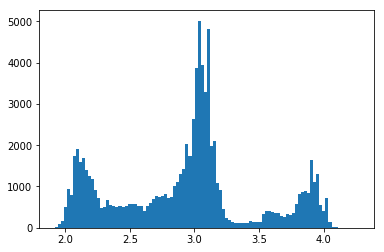

In [149]:
plt.hist(preds,bins=100);

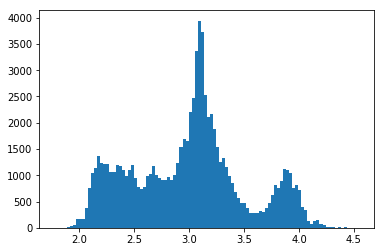

In [63]:
plt.hist(preds,bins=100);

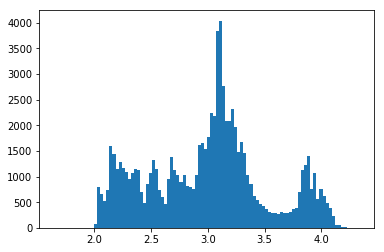

In [55]:
plt.hist(preds,bins=100);

In [64]:
np.mean(np.abs(y[test]-preds))

0.46227166495258259

In [53]:
np.mean(np.abs(y[test]-preds))

0.46789203230142168

In [48]:
np.mean(np.abs(y[test]-preds))

0.47344386092546731

In [43]:
np.mean(np.abs(y[test]-preds))

0.47062163109722832

In [146]:
np.mean(np.abs(y[test]-preds))

0.44758818829783753

In [148]:
np.mean((y[test]-preds)**2)

0.38954979707996923

In [220]:
def find_num_trees():
    early_stopping_rounds = 5
    num_round = 10000
    trees = []
    for train,test in cv.split(X,y,groups):
        dtrain = xgb.DMatrix(X[train],label=y[train])
        dtest = xgb.DMatrix(X[test],label=y[test])
        watchlist  = [(dtrain,'train'),(dtest,'eval')]
        bst = xgb.train(params,dtrain,num_round,watchlist,psuedo_huber,
                        early_stopping_rounds=early_stopping_rounds,verbose_eval=False)
        trees.append(bst.best_iteration)
    return int(round(np.mean(trees)))

In [223]:
etas = [.05,.01,.005]
lamdas = [5,10,20]
max_depths = [8,12,15]
deltas = [.5,.8]

In [226]:
results = {}
params = {'objective':'reg:linear','eval_metric':'mae','min_child_weight':20,'subsample':.9,'tree_method':'approx'}
stopping_rounds = {.005:50,.01:30,.05:15}
for eta,lamda,max_depth,delta in itertools.product(etas,lamdas,max_depths,deltas):
    print eta,lamda,max_depth,delta
    params['eta'] = eta
    params['lambda'] = lamda
    params['max_depth'] = max_depth
    psuedo_huber.delta = delta
    early_stopping_rounds = stopping_rounds[eta]
    
    cols = ['Distance_from_hole','Start_Z_Coordinate','Green_to_work_with']
    X = data_[cols].values
    y = data_.Strokes_from_starting_location.values
    lb = LabelBinarizer(sparse_output=True)
    cols = ['Course_#',['Course_#','Year'],['Course_#','Year','Round'],['Course_#','Hole']]
    to_encode = []
    for col in cols:
        if isinstance(col,str):
            to_encode.append([str(s) for s in data_[col].values])
        else:
            to_encode.append(['-'.join(map(str,tup)) for tup in data_[col].values])
    X_ = bmat([[lb.fit_transform(c) for c in to_encode]],format='csc')
    X = bmat([[csc_matrix(X),X_]],format='csc')
    
    groups = ['-'.join(map(str,tup)) for tup in data_[id_cols].values.tolist()]
    groups = le.fit_transform(groups)
    groups_dict = {group:u for u,group in enumerate(set(groups))}
    perm = np.random.permutation(len(groups_dict))
    groups = [perm[groups_dict[group]] for group in groups]
    
    num_round = 10000
    num_trees = find_num_trees()
    
    groups = ['-'.join(map(str,tup)) for tup in data_[id_cols].values.tolist()]
    groups = le.fit_transform(groups)
    groups_dict = {group:u for u,group in enumerate(set(groups))}
    perm = np.random.permutation(len(groups_dict))
    groups = [perm[groups_dict[group]] for group in groups]
    
    errors = []
    for train,test in cv.split(X,y,groups):
        dtrain = xgb.DMatrix(X[train],label=y[train])
        dtest = xgb.DMatrix(X[test])
        bst = xgb.train(params,dtrain,num_trees,obj=psuedo_huber)
        error = np.mean(np.abs(bst.predict(dtest) - y[test]))
        print error,',',
        errors.append(error)
    print
    X_ = bmat([[lb.fit_transform(data_[col].values) for col in ['loc_string','loc_string_hole']]],format='csc')
    X = bmat([[X,X_]],format='csc')
    
    groups = ['-'.join(map(str,tup)) for tup in data_[id_cols].values.tolist()]
    groups = le.fit_transform(groups)
    groups_dict = {group:u for u,group in enumerate(set(groups))}
    perm = np.random.permutation(len(groups_dict))
    groups = [perm[groups_dict[group]] for group in groups]
    
    num_round = 10000
    num_trees = find_num_trees()
    
    groups = ['-'.join(map(str,tup)) for tup in data_[id_cols].values.tolist()]
    groups = le.fit_transform(groups)
    groups_dict = {group:u for u,group in enumerate(set(groups))}
    perm = np.random.permutation(len(groups_dict))
    groups = [perm[groups_dict[group]] for group in groups]
    
    errors2 = []
    for train,test in cv.split(X,y,groups):
        dtrain = xgb.DMatrix(X[train],label=y[train])
        dtest = xgb.DMatrix(X[test])
        bst = xgb.train(params,dtrain,num_trees,obj=psuedo_huber)
        error = np.mean(np.abs(bst.predict(dtest) - y[test]))
        print error,',',
        errors2.append(error)
    print
    results[(eta,lamda,max_depth,delta)] = (errors,errors2)
    

 0.05 5 8 0.5
0.467736321259 , 0.466186522161 , 0.464965609323 , 0.465648173561 , 0.464307333793 , 0.464693774733 , 0.464355013169 , 0.466140154979 , 0.464266239244 , 0.464728575508 , 0.465564364193 , 0.468362960219 , 0.465350273449 , 0.464613149381 , 0.464057691914 ,
0.467312383433 , 0.467752502809 , 0.463872726131 , 0.460960191197 , 0.462289511776 , 0.467717547249 , 0.463338011433 , 0.462446428303 , 0.4667423558 , 0.46256679304 , 0.465792665518 , 0.46523928041 , 0.466645997352 , 0.465195333481 , 0.466318848918 ,
0.05 5 8 0.8
0.472264323464 , 0.469743909369 , 0.472623913932 , 0.470905098864 , 0.469578287509 , 0.467629396049 , 0.470114102632 , 0.472171791705 , 0.469056407805 , 0.469917772689 , 0.470406983137 , 0.468858167258 , 0.470991989612 , 0.469475715865 , 0.470507125868 ,
0.47414330327 , 0.469692487452 , 0.466440185358 , 0.46870500504 , 0.469785518268 , 0.470449963256 , 0.471959315413 , 0.471129965217 , 0.470218123692 , 0.468215324064 , 0.472859757971 , 0.468408228227 , 0.47102506

KeyboardInterrupt: 

In [231]:
etas = [.01,.005]
lamdas = [5,10]
max_depths = [8]
deltas = [.5,.3]

In [232]:
cols = ['Distance_from_hole','Start_Z_Coordinate','Green_to_work_with']
X = data_[cols].values
y = data_.Strokes_from_starting_location.values
lb = LabelBinarizer(sparse_output=True)
cols = ['Course_#',['Course_#','Year'],['Course_#','Year','Round'],['Course_#','Hole']]
to_encode = []
for col in cols:
    if isinstance(col,str):
        to_encode.append([str(s) for s in data_[col].values])
    else:
        to_encode.append(['-'.join(map(str,tup)) for tup in data_[col].values])
X_ = bmat([[lb.fit_transform(c) for c in to_encode]],format='csc')
X = bmat([[csc_matrix(X),X_]],format='csc')

In [234]:
num_trees

566

In [233]:
results2 = {}
params = {'objective':'reg:linear','eval_metric':'mae','min_child_weight':20,'subsample':.9,'tree_method':'approx'}
stopping_rounds = {.005:50,.01:30,.05:15}
for eta,lamda,max_depth,delta in itertools.product(etas,lamdas,max_depths,deltas):
    print eta,lamda,max_depth,delta
    params['eta'] = eta
    params['lambda'] = lamda
    params['max_depth'] = max_depth
    psuedo_huber.delta = delta
    early_stopping_rounds = stopping_rounds[eta]
    
    groups = ['-'.join(map(str,tup)) for tup in data_[id_cols].values.tolist()]
    groups = le.fit_transform(groups)
    groups_dict = {group:u for u,group in enumerate(set(groups))}
    perm = np.random.permutation(len(groups_dict))
    groups = [perm[groups_dict[group]] for group in groups]
    
    num_round = 10000
    num_trees = find_num_trees()
    
    groups = ['-'.join(map(str,tup)) for tup in data_[id_cols].values.tolist()]
    groups = le.fit_transform(groups)
    groups_dict = {group:u for u,group in enumerate(set(groups))}
    perm = np.random.permutation(len(groups_dict))
    groups = [perm[groups_dict[group]] for group in groups]
    
    errors = []
    for train,test in cv.split(X,y,groups):
        dtrain = xgb.DMatrix(X[train],label=y[train])
        dtest = xgb.DMatrix(X[test])
        bst = xgb.train(params,dtrain,num_trees,obj=psuedo_huber)
        error = np.mean(np.abs(bst.predict(dtest) - y[test]))
        print error,',',
        errors.append(error)
    print
    results2[(eta,lamda,max_depth,delta)] = (errors)
    

0.01 5 8 0.5
0.460455232498 , 0.46066901705 , 0.460604317002 , 0.46052630656 , 0.459333837179 , 0.461788519514 , 0.463929572937 , 0.461994361219 , 0.462966745731 , 0.461789071179 , 0.462865440253 , 0.459996698801 , 0.461368407211 , 0.46395130647 , 0.461461305742 ,
0.01 5 8 0.3
0.450339302669 , 0.451134491353 , 0.451802792233 , 0.451728974909 , 0.450338489747 , 0.450236718083 , 0.450516231029 , 0.450051683742 , 0.445722230388 , 0.444604386545 , 0.446774546414 , 0.453124655308 , 0.448134574321 , 0.450853628897 , 0.448519807943 ,
0.01 10 8 0.5
0.463887490402 , 0.464364800272 , 0.465769704543 , 0.463548892115 , 0.461585415756 , 0.459707354689 , 0.459722444834 , 0.46147466676 , 0.460592161144 , 0.46399332529 , 0.459964783312 , 0.461838998126 , 0.459928350008 , 0.459016294146 , 0.460291116183 ,
0.01 10 8 0.3
0.450270314268 , 0.448859696759 , 0.450799036614 , 0.452783052506 , 0.449126944023 , 0.44865524427 , 0.451487447925 , 0.44978031336 , 0.445957123764 , 0.450756881116 , 0.451070248725 , 0

KeyboardInterrupt: 

In [144]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    resids = np.abs(preds - labels)
    return 'error', np.mean([np.mean(resids),np.percentile(resids,80),np.percentile(resids,99)])

In [145]:
params = {'objective':'reg:linear','eval_metric':'mae','min_child_weight':20,'subsample':.9,'tree_method':'approx',
          'eta':.015,'lambda':5,'max_depth':8,'base_score':y.mean()}
#psuedo_huber.delta = 93
psuedo_huber.delta = .75

In [146]:
early_stopping_rounds = 8
num_round = 10000
watchlist  = [(dtrain,'train'),(dtest,'eval')]

In [336]:
import sys

In [337]:
f = open('log.txt','w')

In [338]:
old_sys_out = sys.stdout

In [339]:
sys.stdout = f

In [147]:
bst = xgb.train(params,dtrain,num_round,watchlist,psuedo_huber,evalerror,
                early_stopping_rounds=early_stopping_rounds,verbose_eval=True)

[0]	train-mae:0.461619	eval-mae:0.460596	train-error:1.14935	eval-error:1.14887
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 8 rounds.
[1]	train-mae:0.459049	eval-mae:0.458035	train-error:1.14408	eval-error:1.14346
[2]	train-mae:0.456566	eval-mae:0.455556	train-error:1.13877	eval-error:1.13815
[3]	train-mae:0.454203	eval-mae:0.453198	train-error:1.13334	eval-error:1.13301
[4]	train-mae:0.452106	eval-mae:0.451111	train-error:1.12839	eval-error:1.12806
[5]	train-mae:0.450216	eval-mae:0.44924	train-error:1.12384	eval-error:1.12306
[6]	train-mae:0.448511	eval-mae:0.447543	train-error:1.1192	eval-error:1.11888
[7]	train-mae:0.446936	eval-mae:0.445971	train-error:1.11401	eval-error:1.11369
[8]	train-mae:0.445488	eval-mae:0.444526	train-error:1.10956	eval-error:1.10924
[9]	train-mae:0.444157	eval-mae:0.443188	train-error:1.10549	eval-error:1.10483
[10]	train-mae:0.442917	eval-mae:0.44194	train-error:1.101

In [148]:
preds = bst.predict(dtest)

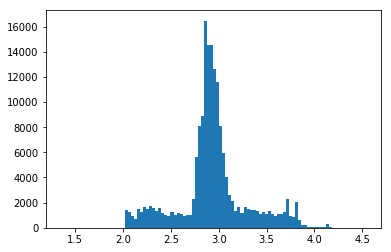

In [149]:
plt.hist(preds,bins=100);

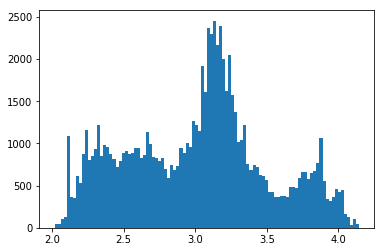

In [125]:
plt.hist(preds,bins=100);

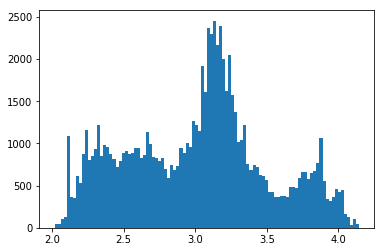

In [108]:
plt.hist(preds,bins=100);

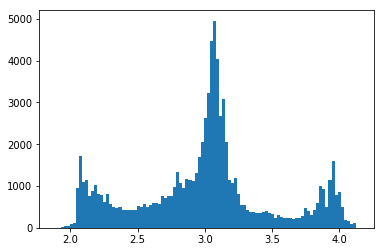

In [93]:
plt.hist(preds,bins=100);

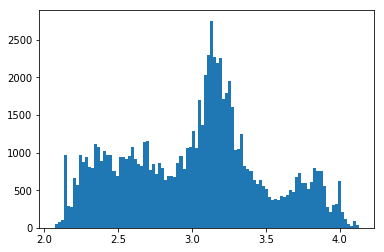

In [78]:
plt.hist(preds,bins=100);

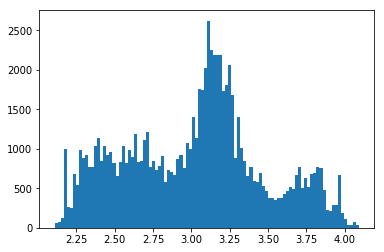

In [28]:
plt.hist(preds,bins=100);

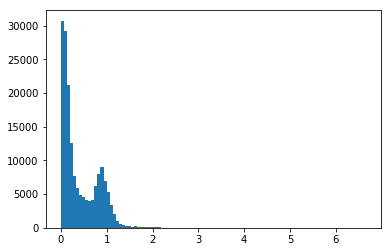

In [150]:
plt.hist(np.abs(preds-y[test]),bins=100);

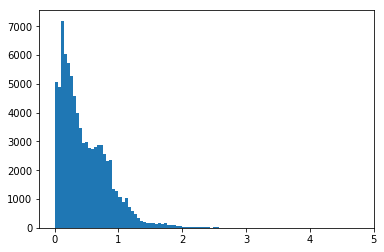

In [126]:
plt.hist(np.abs(preds-y[test]),bins=100);

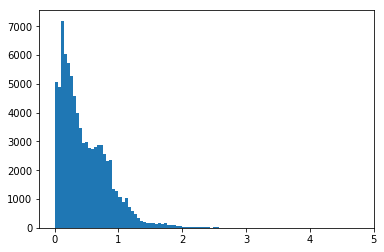

In [109]:
plt.hist(np.abs(preds-y[test]),bins=100);

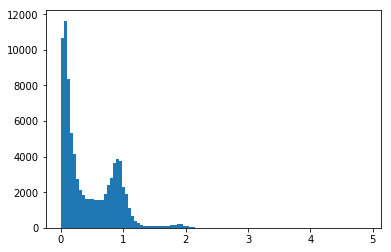

In [94]:
plt.hist(np.abs(preds-y[test]),bins=100);

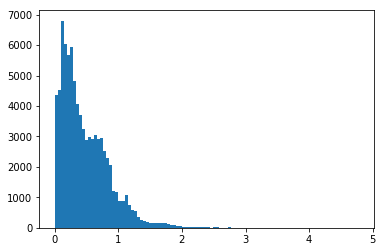

In [63]:
plt.hist(np.abs(preds-y[test]),bins=100);

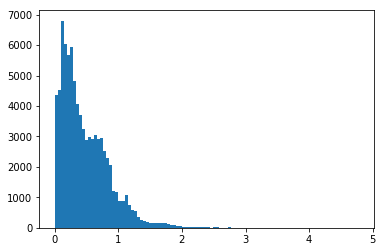

In [81]:
plt.hist(np.abs(preds-y[test]),bins=100);

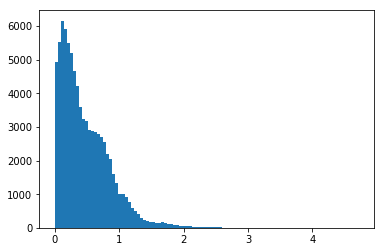

In [17]:
plt.hist(np.abs(preds-y[test]),bins=100);

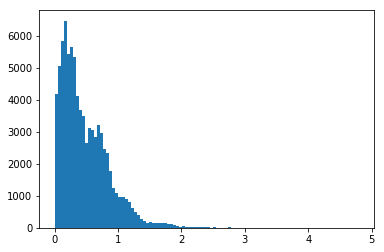

In [29]:
plt.hist(np.abs(preds-y[test]),bins=100);

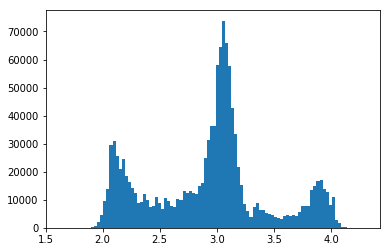

In [240]:
plt.hist(np.abs(preds-y[test]),bins=100);

In [152]:
X.shape

(2612728, 4481)

In [154]:
elev = 0
gtww = 10
x, y1, y2 = [], [], []
for dist in np.linspace(0.01,1500,1000):
    x.append(dist)
    X_ = np.concatenate([np.array([dist,elev,gtww]),np.zeros(4478)]).reshape(1,-1)
    X_ = xgb.DMatrix(csc_matrix(X_))
    pred = bst.predict(X_)
    y1.append(pred)
    X_ = np.concatenate([np.array([dist,elev,gtww]),[1],np.zeros(4477)]).reshape(1,-1)
    X_ = xgb.DMatrix(csc_matrix(X_))
    pred = bst.predict(X_)
    y2.append(pred)

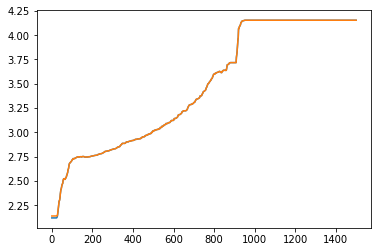

In [155]:
plt.plot(x,y1);
plt.plot(x,y2);

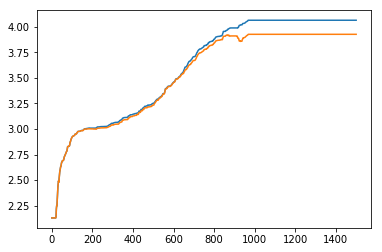

In [128]:
plt.plot(x,y1);
plt.plot(x,y2);

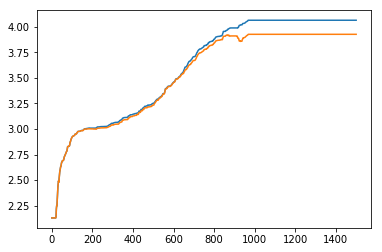

In [111]:
plt.plot(x,y1);
plt.plot(x,y2);

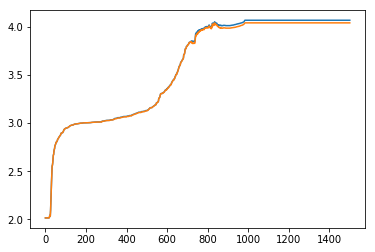

In [96]:
plt.plot(x,y1);
plt.plot(x,y2);

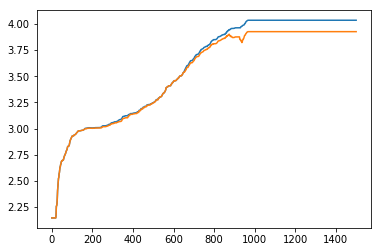

In [80]:
plt.plot(x,y1);
plt.plot(x,y2);

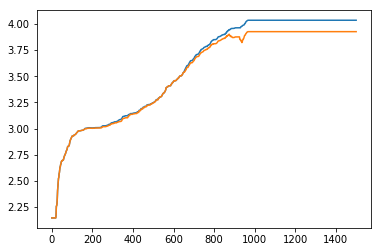

In [65]:
plt.plot(x,y1);
plt.plot(x,y2);

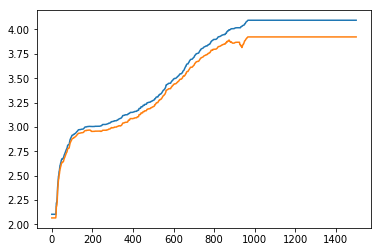

In [31]:
plt.plot(x,y1);
plt.plot(x,y2);

In [156]:
elev = 0
dist = 100
x, y1, y2 = [], [], []
for gtww in np.linspace(5,80,1000):
    x.append(gtww)
    X_ = np.concatenate([np.array([dist,elev,gtww]),np.zeros(4478)]).reshape(1,-1)
    X_ = xgb.DMatrix(csc_matrix(X_))
    pred = bst.predict(X_)
    y1.append(pred)
    X_ = np.concatenate([np.array([dist,elev,gtww]),[1],np.zeros(4477)]).reshape(1,-1)
    X_ = xgb.DMatrix(csc_matrix(X_))
    pred = bst.predict(X_)
    y2.append(pred)

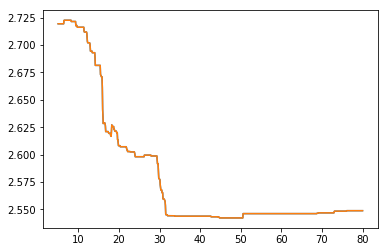

In [157]:
plt.plot(x,y1);
plt.plot(x,y2);

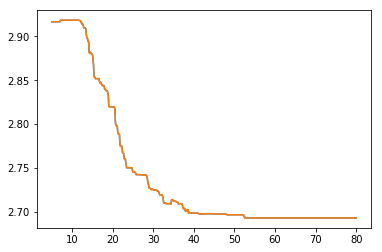

In [130]:
plt.plot(x,y1);
plt.plot(x,y2);

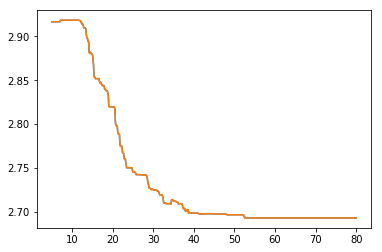

In [113]:
plt.plot(x,y1);
plt.plot(x,y2);

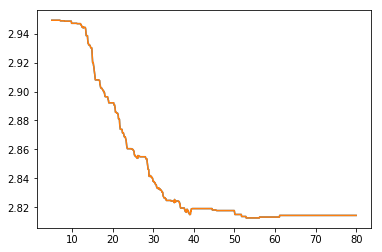

In [98]:
plt.plot(x,y1);
plt.plot(x,y2);

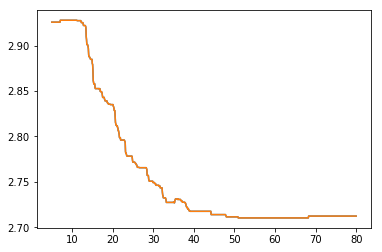

In [83]:
plt.plot(x,y1);
plt.plot(x,y2);

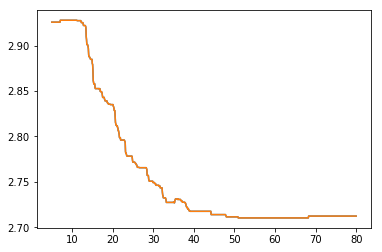

In [67]:
plt.plot(x,y1);
plt.plot(x,y2);

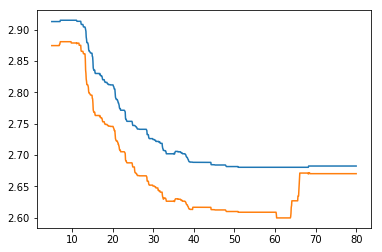

In [33]:
plt.plot(x,y1);
plt.plot(x,y2);

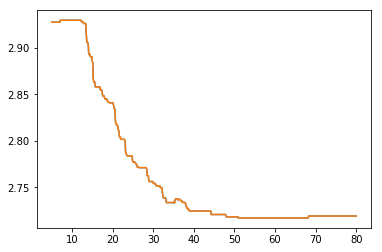

In [21]:
plt.plot(x,y1);
plt.plot(x,y2);

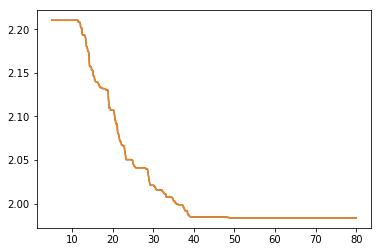

In [327]:
plt.plot(x,y1);
plt.plot(x,y2);

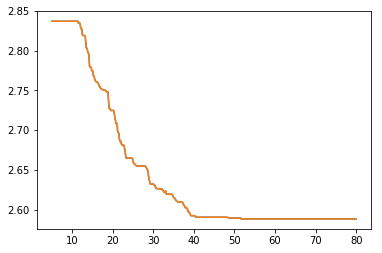

In [324]:
plt.plot(x,y1);
plt.plot(x,y2);

In [158]:
gtww = 30
dist = 100
x, y1, y2 = [], [], []
for elev in np.linspace(-8,8,1000):
    x.append(elev)
    X_ = np.concatenate([np.array([dist,elev,gtww]),np.zeros(4478)]).reshape(1,-1)
    X_ = xgb.DMatrix(csc_matrix(X_))
    pred = bst.predict(X_)
    y1.append(pred)
    X_ = np.concatenate([np.array([dist,elev,gtww]),[1],np.zeros(4477)]).reshape(1,-1)
    X_ = xgb.DMatrix(csc_matrix(X_))
    pred = bst.predict(X_)
    y2.append(pred)

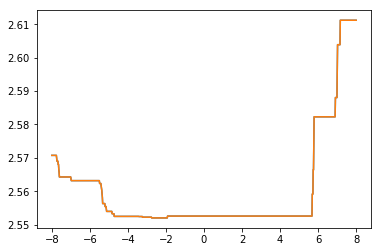

In [159]:
plt.plot(x,y1);
plt.plot(x,y2);

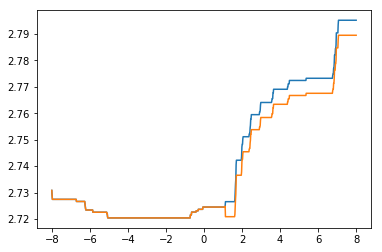

In [132]:
plt.plot(x,y1);
plt.plot(x,y2);

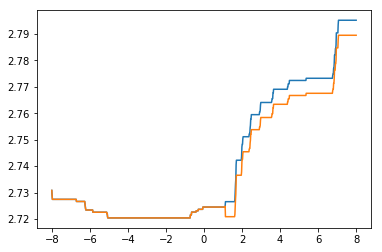

In [115]:
plt.plot(x,y1);
plt.plot(x,y2);

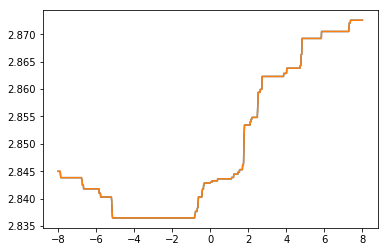

In [100]:
plt.plot(x,y1);
plt.plot(x,y2);

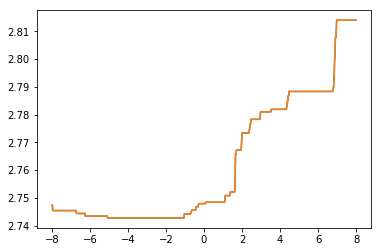

In [85]:
plt.plot(x,y1);
plt.plot(x,y2);

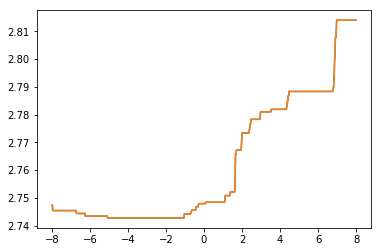

In [69]:
plt.plot(x,y1);
plt.plot(x,y2);

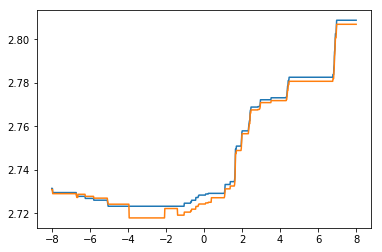

In [46]:
plt.plot(x,y1);
plt.plot(x,y2);

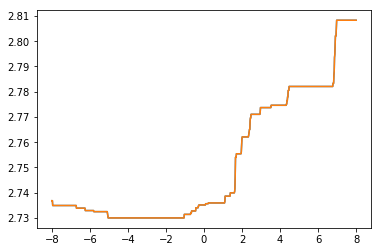

In [44]:
plt.plot(x,y1);
plt.plot(x,y2);

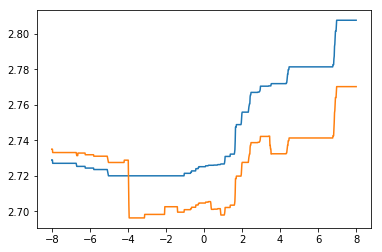

In [42]:
plt.plot(x,y1);
plt.plot(x,y2);

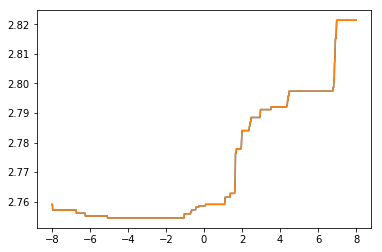

In [39]:
plt.plot(x,y1);
plt.plot(x,y2);

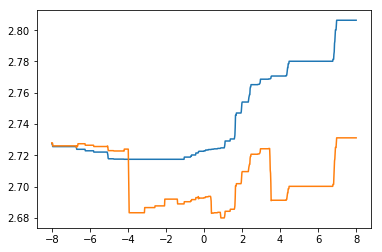

In [35]:
plt.plot(x,y1);
plt.plot(x,y2);

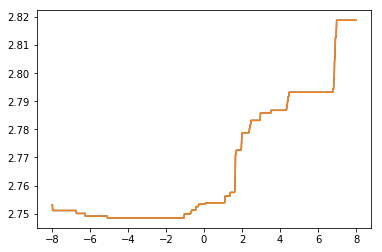

In [23]:
plt.plot(x,y1);
plt.plot(x,y2);

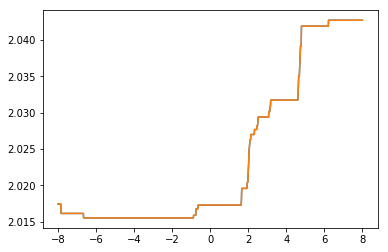

In [331]:
plt.plot(x,y1);
plt.plot(x,y2);

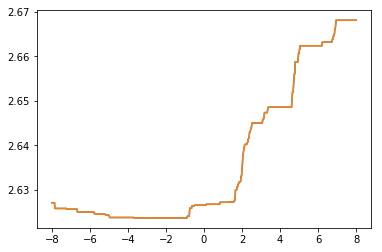

In [329]:
plt.plot(x,y1);
plt.plot(x,y2);

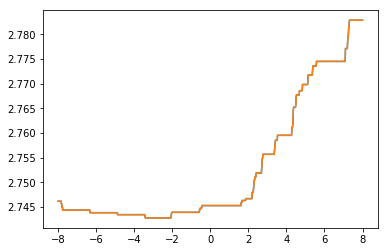

In [300]:
plt.plot(x,y1);
plt.plot(x,y2);

In [161]:
elev = 0
dist = 100
x, y1, y2 = [], [], []
for gtww in np.linspace(5,80,1000):
    x.append(gtww)
    X_ = np.concatenate([np.array([dist,-5,gtww]),np.zeros(4478)]).reshape(1,-1)
    X_ = xgb.DMatrix(csc_matrix(X_))
    pred = bst.predict(X_)
    y1.append(pred)
    X_ = np.concatenate([np.array([dist,5,gtww]),np.zeros(4478)]).reshape(1,-1)
    X_ = xgb.DMatrix(csc_matrix(X_))
    pred = bst.predict(X_)
    y2.append(pred)

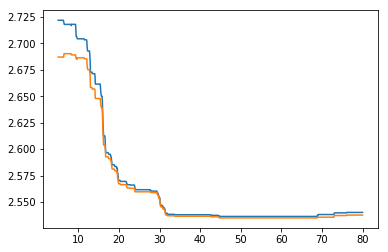

In [162]:
plt.plot(x,y1);
plt.plot(x,y2);

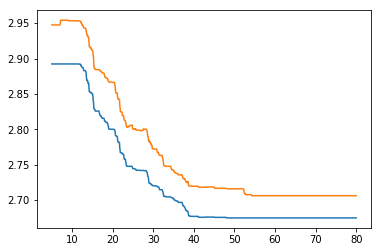

In [134]:
plt.plot(x,y1);
plt.plot(x,y2);

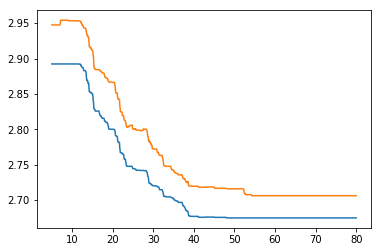

In [117]:
plt.plot(x,y1);
plt.plot(x,y2);

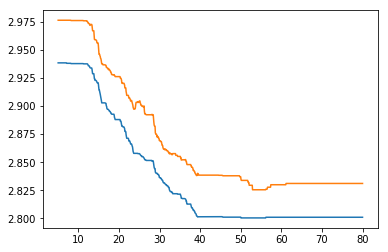

In [102]:
plt.plot(x,y1);
plt.plot(x,y2);

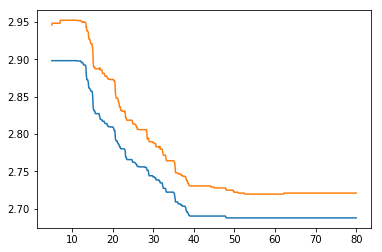

In [87]:
plt.plot(x,y1);
plt.plot(x,y2);

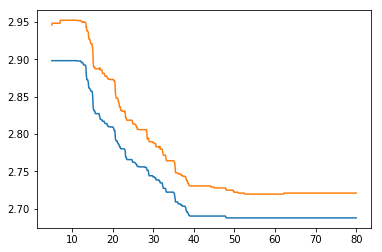

In [71]:
plt.plot(x,y1);
plt.plot(x,y2);

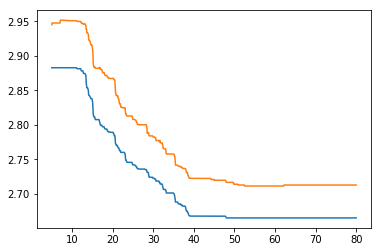

In [50]:
plt.plot(x,y1);
plt.plot(x,y2);

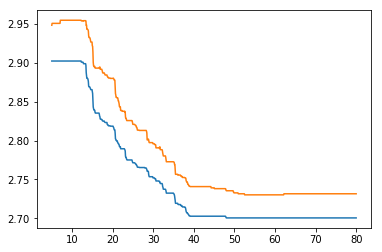

In [53]:
plt.plot(x,y1);
plt.plot(x,y2);

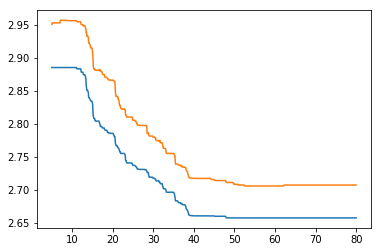

In [25]:
plt.plot(x,y1);
plt.plot(x,y2);

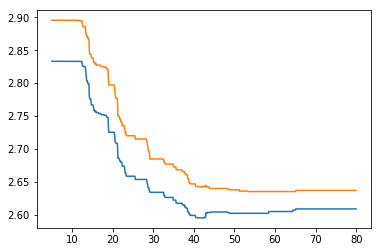

In [283]:
plt.plot(x,y1);
plt.plot(x,y2);

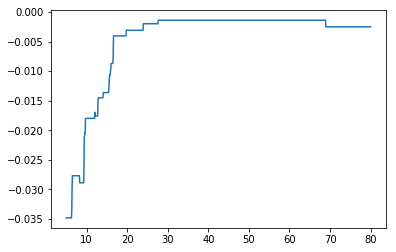

In [163]:
plt.plot(x,np.array(y2)-np.array(y1));

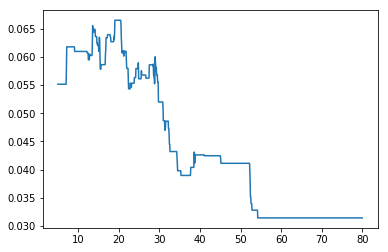

In [135]:
plt.plot(x,np.array(y2)-np.array(y1));

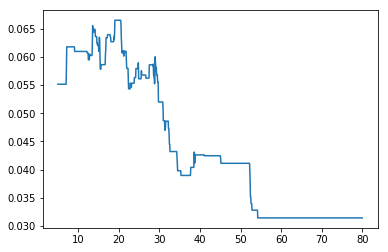

In [119]:
plt.plot(x,np.array(y2)-np.array(y1));

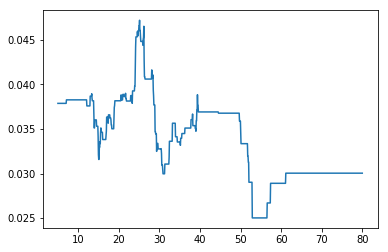

In [103]:
plt.plot(x,np.array(y2)-np.array(y1));

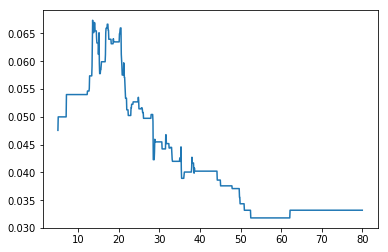

In [88]:
plt.plot(x,np.array(y2)-np.array(y1));

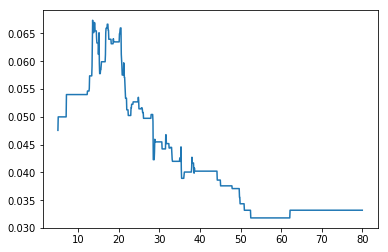

In [72]:
plt.plot(x,np.array(y2)-np.array(y1));

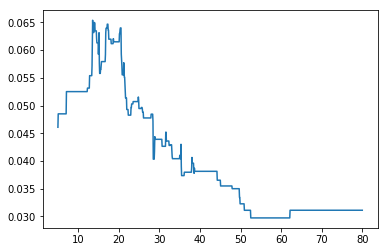

In [54]:
plt.plot(x,np.array(y2)-np.array(y1));

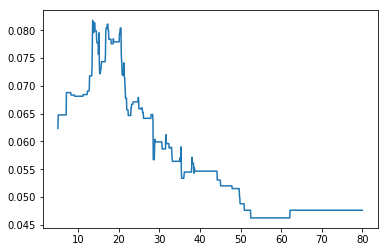

In [51]:
plt.plot(x,np.array(y2)-np.array(y1));

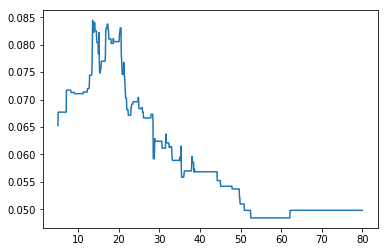

In [26]:
plt.plot(x,np.array(y2)-np.array(y1));

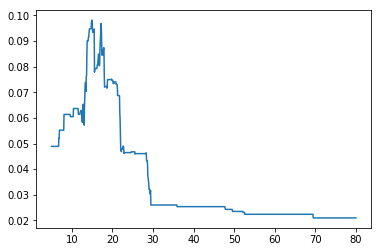

In [303]:
plt.plot(x,np.array(y2)-np.array(y1));

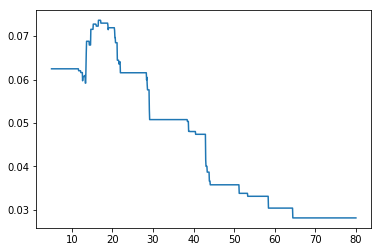

In [288]:
plt.plot(x,np.array(y2)-np.array(y1));